In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- 1. Mount Google Drive ---
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- 2. Load Data ---
# Ubah path di bawah sesuai dengan lokasi file di Drive Anda
path = '/content/drive/MyDrive/Colab Notebooks/AI_Class/online_retail_II.xlsx'
df = pd.read_excel(path)

In [3]:
# 1. Cleaning: Hapus baris tanpa Customer ID dan Quantity negatif (retur)
df.dropna(subset=['Customer ID'], inplace=True)
df = df[df['Quantity'] > 0]

# 2. Membuat Fitur RFM
# Menghitung total harga per baris
df['TotalPrice'] = df['Quantity'] * df['Price']

# Menentukan tanggal referensi (hari terakhir di dataset + 1)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Agregasi data per pelanggan
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                    # Monetary
})

# Rename kolom
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# 3. Membuat Label (Target)
# Kita anggap pelanggan setia (1) jika Frequency > 2 kali belanja
rfm['IsLoyal'] = (rfm['Frequency'] > 2).astype(int)

print("Statistik RFM:")
print(rfm.describe())

Statistik RFM:
           Recency    Frequency       Monetary      IsLoyal
count  4314.000000  4314.000000    4314.000000  4314.000000
mean     91.269124     4.454103    2047.288659     0.482847
std      96.943482     8.168658    8912.523243     0.499764
min       1.000000     1.000000       0.000000     0.000000
25%      18.000000     1.000000     307.950000     0.000000
50%      53.000000     2.000000     705.550000     0.000000
75%     136.000000     5.000000    1722.802500     1.000000
max     374.000000   205.000000  349164.350000     1.000000


In [4]:
# Pisahkan fitur dan target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['IsLoyal']

# Split data 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalisasi data agar Neural Network bekerja maksimal
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Jumlah Data Training: {len(X_train)}")
print(f"Jumlah Data Testing: {len(X_test)}")

Jumlah Data Training: 3019
Jumlah Data Testing: 1295


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Arsitektur Model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)), # Input layer
    Dropout(0.2),                                                  # Mencegah overfitting
    Dense(8, activation='relu'),                                   # Hidden layer
    Dense(1, activation='sigmoid')                                 # Output layer (0 atau 1)
])

# Kompilasi Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Proses Training
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, # Validasi internal saat training
                    verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6149 - loss: 0.6445 - val_accuracy: 0.8460 - val_loss: 0.5636
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8144 - loss: 0.5374 - val_accuracy: 0.8675 - val_loss: 0.4316
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8651 - loss: 0.4111 - val_accuracy: 0.9321 - val_loss: 0.3038
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9126 - loss: 0.3018 - val_accuracy: 0.9619 - val_loss: 0.2170
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9379 - loss: 0.2189 - val_accuracy: 0.9801 - val_loss: 0.1603
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9597 - loss: 0.1711 - val_accuracy: 0.9851 - val_loss: 0.1186
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9709 - loss: 0.1406 - val_accuracy: 0.9983 - val_loss: 0.0901
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.1149 - val_accuracy: 0.9983 - val_loss:

--------------------------------------------------
Akurasi Akhir Model pada Data Testing: 100.00%
Loss (Tingkat Kesalahan): 0.0003
--------------------------------------------------


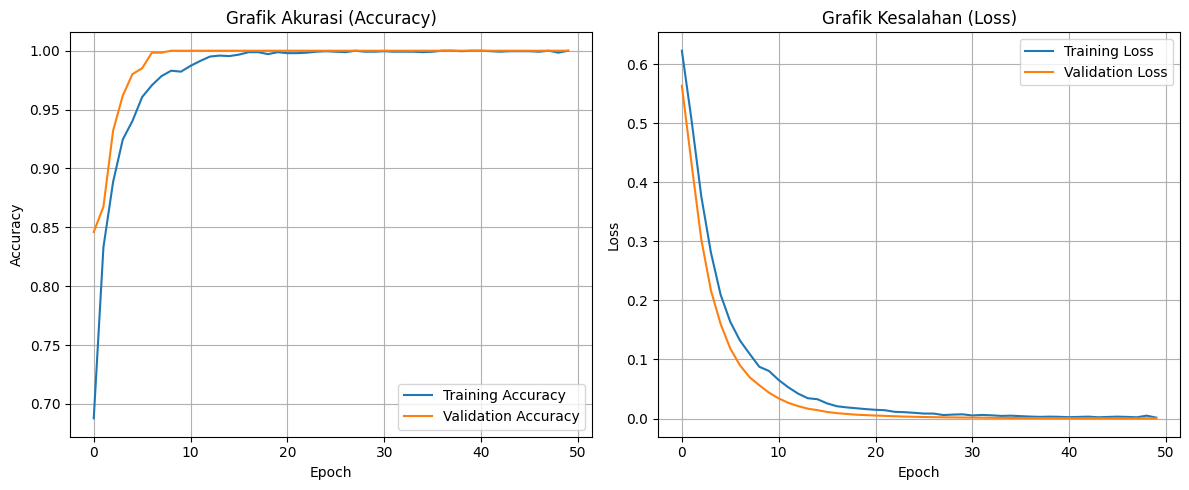

In [8]:
import matplotlib.pyplot as plt # Import ulang untuk memastikan library aktif

# 1. Cek Evaluasi Model
# Pastikan X_test dan y_test sudah ada dari Cell 4
try:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"--------------------------------------------------")
    print(f"Akurasi Akhir Model pada Data Testing: {accuracy*100:.2f}%")
    print(f"Loss (Tingkat Kesalahan): {loss:.4f}")
    print(f"--------------------------------------------------")
except NameError:
    print("Error: Model atau data test tidak ditemukan. Pastikan Cell 4 dan 5 sudah dijalankan.")

# 2. Visualisasi Grafik
# Memastikan variabel 'history' dari Cell 5 sudah ada
if 'history' in locals():
    plt.figure(figsize=(12, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Grafik Akurasi (Accuracy)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Grafik Kesalahan (Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Grafik tidak bisa muncul karena proses training di Cell 5 belum selesai atau error.")